## Imports

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import netCDF4
import cartopy.crs as ccrs
from scipy.interpolate import griddata
from statistics import variance
from scipy.stats import pearsonr
import matplotlib.ticker as mticker

## Load Datasets

In [2]:
# World Ocean Atlas climatology

WOA_dataset = xr.open_dataset('woa23_decav71A0_o00_01.nc', decode_times=False)
WOA = WOA_dataset.o_an.squeeze(dim='time').drop('time')
WOA_california = WOA.sel(lat=slice(30, 50), lon=slice(-130,-120))

/var/folders/__/9_qbc5px45zbc1g2trrxp8jw0000gn/T/ipykernel_78390/4167572819.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  WOA = WOA_dataset.o_an.squeeze(dim='time').drop('time')


In [3]:
WOA_sd = WOA_dataset.o_sd.squeeze(dim='time').drop('time')
WOA_sd_california = WOA_sd.sel(lat=slice(30,50), lon=slice(-130,-120))

/var/folders/__/9_qbc5px45zbc1g2trrxp8jw0000gn/T/ipykernel_78390/2173620213.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  WOA_sd = WOA_dataset.o_sd.squeeze(dim='time').drop('time')


In [4]:
# Model data

O2min = xr.open_dataset('California_O2min_regridded.nc').O2_ZMIN
O2min = O2min.sel(time=slice('1971','2000'))

O2_model_gridded = xr.open_dataarray('California_O2full_regridded.nc')
O2_model_gridded = O2_model_gridded.sel(time=slice('1971','2000'))

# Plots

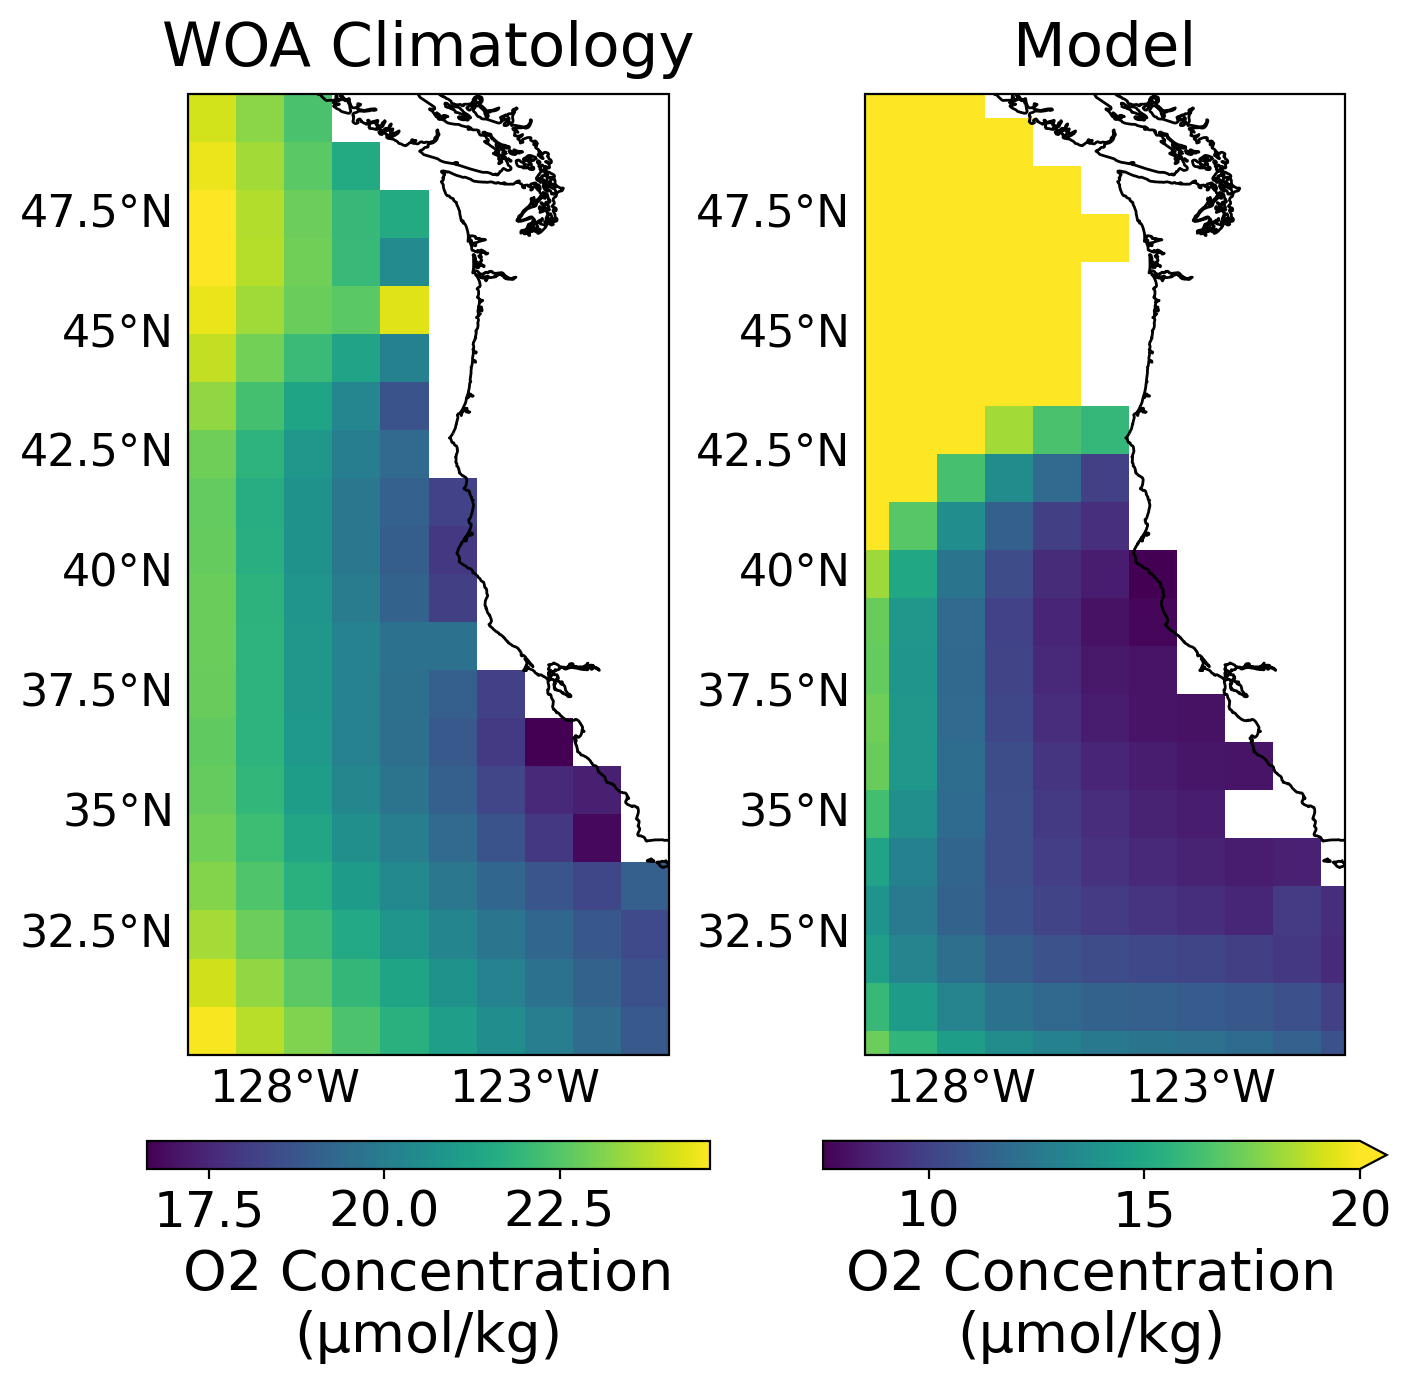

In [5]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8,8), dpi=200)

for axis in ax:
    axis.coastlines()
    axis.set_extent([-130, -120, 30, 50])
    gl = axis.gridlines(crs=ccrs.PlateCarree(), alpha=0)
    gl.xlocator = mticker.FixedLocator([-128, -123])
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlabel_style = {'size':16}
    gl.ylabel_style = {'size':16}


WOAplot = ax[0].pcolormesh(WOA_california.lon, WOA_california.lat, 
                           WOA_california.sel(depth=slice(500,1000)).mean('depth'))
cbar = plt.colorbar(WOAplot, ax=ax[0], orientation='horizontal', pad=0.07)
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('O2 Concentration\n(µmol/kg)', fontsize=20)
ax[0].set_title('WOA Climatology', pad=10, fontsize=22)

modelplot = ax[1].pcolormesh(O2_model_gridded.lon, O2_model_gridded.lat, 
                             O2_model_gridded.sel(z_t=slice(500,1000)).mean('z_t').mean('time'), 
                             vmax=20)
cbar = plt.colorbar(modelplot, ax=ax[1], orientation='horizontal', pad=0.07, extend='max')
# cbar = plt.colorbar(modelplot, ax=ax[:], orientation='horizontal', pad=0.08, extend='max')
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_xlabel('O2 Concentration\n(µmol/kg)', fontsize=20)
# cbar.set_ticks(np.array([50, 100, 150, 200, 250]))
ax[1].set_title('Model', pad=10, fontsize=22)

# ax[0].text(-0.25, 0.5, 'WOA Climatology', rotation='vertical', horizontalalignment='left', verticalalignment='center', 
#              transform=ax[0].transAxes, fontsize=22)
# ax[1].text(-0.25, 0.5, 'Model', rotation='vertical', horizontalalignment='left', verticalalignment='center', 
#              transform=ax[1].transAxes, fontsize=22)

fig.patch.set_fill(False)

plt.show()

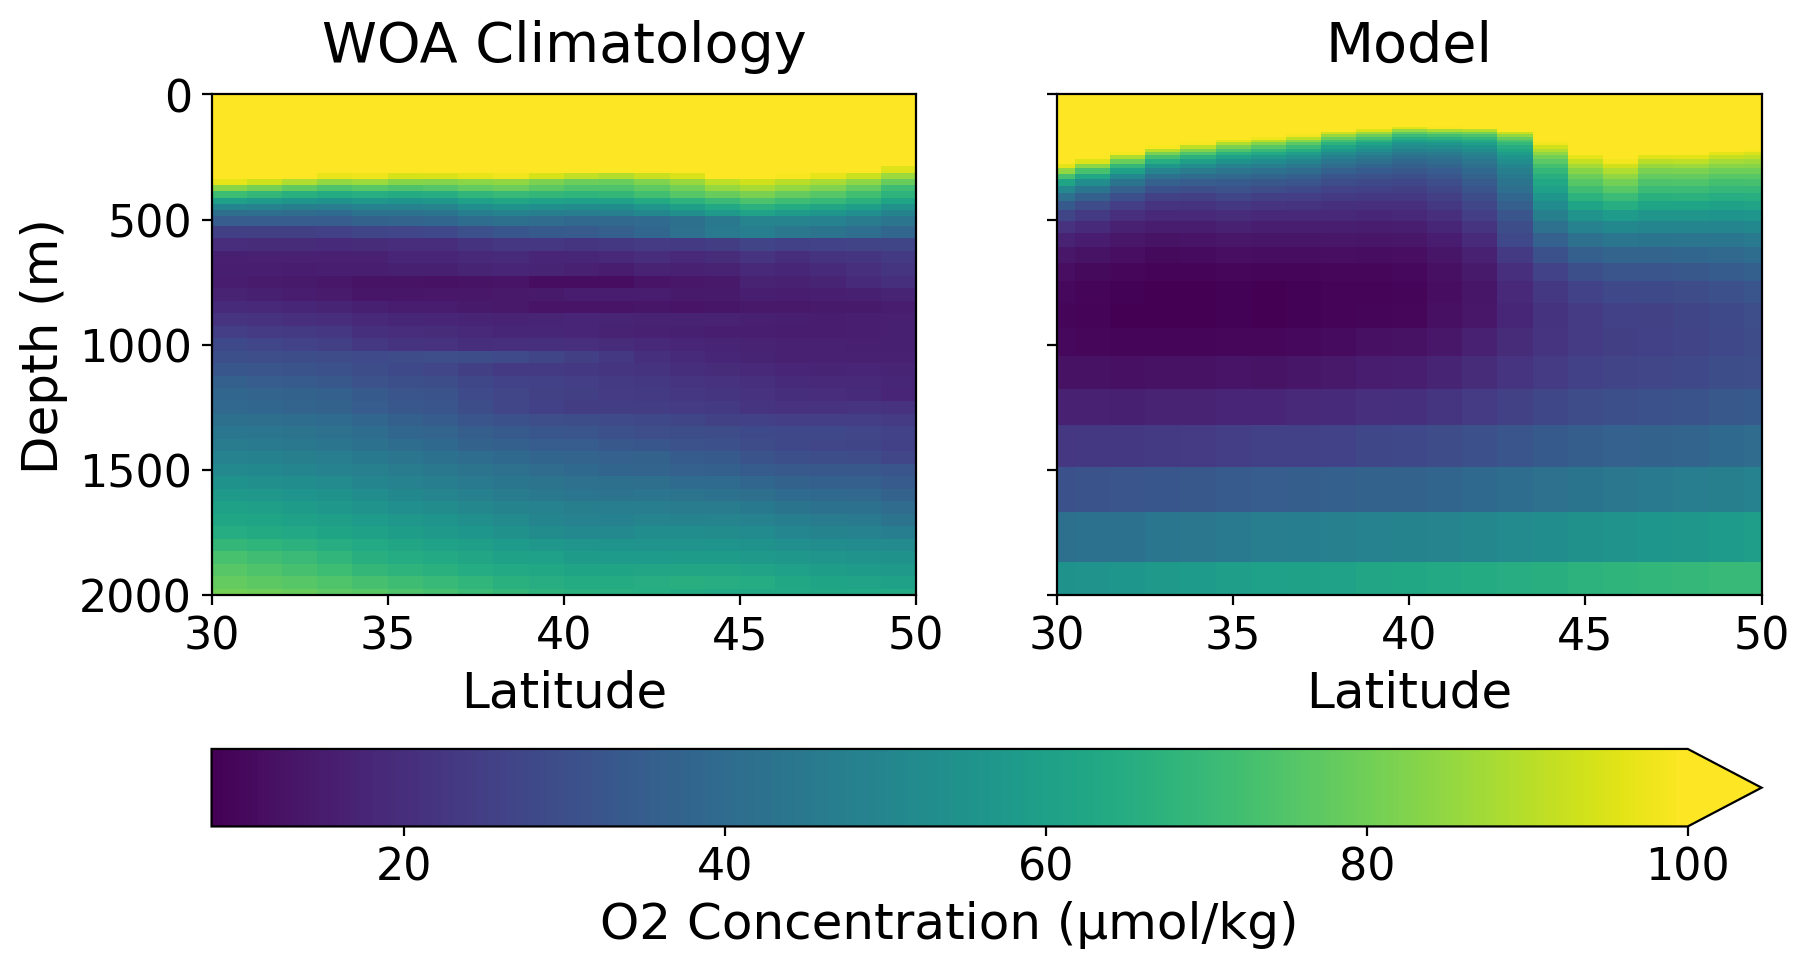

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True, dpi=200)

WOA_slice = WOA_california.sel(depth=slice(0,2000)).mean('lon')
WOAplot = ax[0].pcolormesh(WOA_slice.lat, WOA_slice.depth, WOA_slice, vmin=8, vmax=100)
ax[0].set_ylabel('Depth (m)', fontsize=18)
ax[0].set_title('WOA Climatology', fontsize=20, pad=12)

model_slice = O2_model_gridded.sel(z_t=slice(0,2000)).mean(dim=('lon','time'))
modelplot = ax[1].pcolormesh(model_slice.lat, model_slice.z_t, model_slice, vmin=8, vmax=100)
ax[1].set_title('Model', fontsize=20, pad=12)

for axis in ax:
    axis.set_xlabel('Latitude', fontsize=18)
    axis.tick_params('both', labelsize=16)
    axis.set_xlim([30,50])

ax[0].invert_yaxis()
ax[0].set_ylim([2000,0])

cbar = plt.colorbar(modelplot, ax=ax[:], pad=0.2, extend='max', orientation='horizontal')
cbar.ax.tick_params(labelsize=16)
cbar.ax.set_xlabel('O2 Concentration (µmol/kg)', fontsize=18)

# plt.subplots_adjust(hspace=0.05)

fig.patch.set_fill(False)
    
# plt.tight_layout()

## Supplemental Figure: Number of Observations

In [7]:
num_obs = WOA_dataset.o_dd
num_obs_cal = num_obs.sel(lat=slice(30,50), lon=slice(-130,-120))
num_obs_slice = num_obs_cal.sel(depth=slice(500,1000)).sum('depth', min_count=1).squeeze('time')

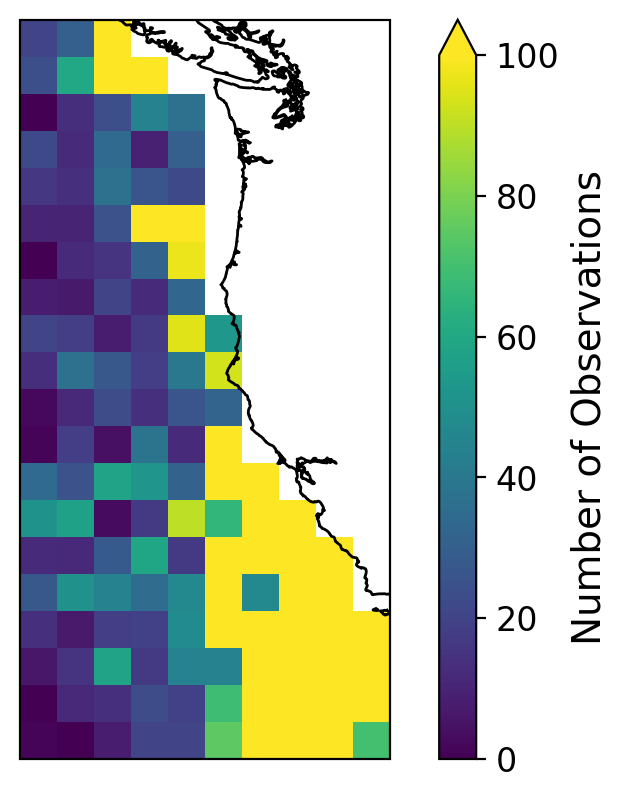

In [8]:
plt.figure(dpi=200)

ax = plt.axes(projection=ccrs.PlateCarree())
pc = ax.pcolormesh(num_obs_slice.lon, num_obs_slice.lat, num_obs_slice, vmax=100)
ax.coastlines()

cbar = plt.colorbar(pc, extend='max')
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Number of Observations', fontsize=14)

plt.show()